# Übung 4 - kNN & SVM
Notwendige Bibliotheken werden geladen.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 4.1 Auszug aus Übung 3

In [3]:
from sklearn import preprocessing

df = pd.read_csv('01_Kundendaten.csv')

df['high revenue'] = np.where(df['total_sum'] > 300, 1, 0)

dfFilter = df[['gender','age_first_order','user_agent_brand',
         'user_agent_os', 'campaign', 'pages_visited_avg','high revenue']]

dfCopy = dfFilter.copy()

dfCopy['gender'] = dfCopy['gender'].fillna(dfCopy['gender'].mode()[0])
dfCopy['age_first_order'] = dfCopy['age_first_order'].fillna(dfFilter['age_first_order'].mode()[0])

dfCopy["campaign"] = dfCopy["campaign"].astype(int)

dfPrepared = dfCopy
dfPrepared.head()

,gender,age_first_order,user_agent_brand,user_agent_os,campaign,pages_visited_avg,high revenue
0,M,19.0,Chrome,MacOS X,1,13.666667,0
1,M,65.0,Firefox,Linux,0,13.666667,0
2,M,38.0,Chrome,MacOS X,0,13.333333,0
3,F,42.0,Chrome,MacOS X,1,12.333333,0
4,M,65.0,Chrome,Windows,1,9.000000,0


## 4.2 One-Hot-Encoding & Normalisierung

In [3]:
dfPrepared = pd.get_dummies(dfPrepared, prefix='',prefix_sep='',columns=['gender','user_agent_brand','user_agent_os', 'campaign'])
dfPrepared.head()

,age_first_order,pages_visited_avg,high revenue,F,M,Chrome,Edge,Firefox,IE,Safari,Linux,MacOS X,Windows,0,1
0,19.0,13.666667,0,0,1,1,0,0,0,0,0,1,0,0,1
1,65.0,13.666667,0,0,1,0,0,1,0,0,1,0,0,1,0
2,38.0,13.333333,0,0,1,1,0,0,0,0,0,1,0,1,0
3,42.0,12.333333,0,1,0,1,0,0,0,0,0,1,0,0,1
4,65.0,9.000000,0,0,1,1,0,0,0,0,0,0,1,0,1


<AxesSubplot:>

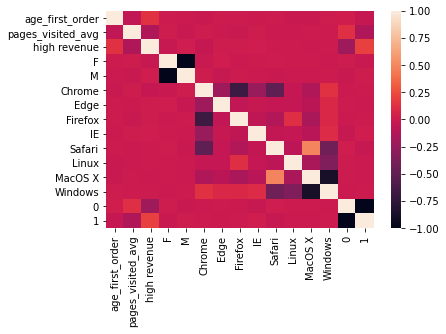

In [4]:
import seaborn as sns

sns.heatmap(dfPrepared.corr())

Die durch One-Hot-Encoding erzeugten Attribute F, M sowie 0, 1 haben eine 100 %-ige Korrelation. Entweder ist die eine Ausprägung aktiv oder die andere. Daher muss jeweils eine Ausprägung entfernt werden.

In [5]:
dfnorm = dfPrepared.drop(['M', '1'], axis = 1)

'Age_first_order' und 'pages_visited_avg' werden normalisiert.

In [6]:
from sklearn.preprocessing import minmax_scale

scaled = minmax_scale(dfnorm[['age_first_order','pages_visited_avg']], feature_range = (0, 1))

dfnorm['age_first_order'] = scaled[:,0] 
dfnorm['pages_visited_avg'] = scaled[:,1]

dfnorm[['age_first_order', 'pages_visited_avg']].head()

,age_first_order,pages_visited_avg
0,0.178082,0.448718
1,0.808219,0.448718
2,0.438356,0.435897
3,0.493151,0.397436
4,0.808219,0.269231


## 4.3 Training & Bewertung der Modelle
kNN und SVM
Im Folgenden werden die Algorithmen xyz trainiert und getestet. Dazu ist hier vorab ein Datensplit von 70 % (Trainingsdaten) zu 30 % (Testdaten) durchgeführt.

In [7]:
from sklearn.model_selection import train_test_split

x = dfnorm.drop(['high revenue'], axis = 1)
y = dfnorm['high revenue'].astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                    random_state = 101, stratify = y, test_size = 0.3)

### A1: k-Nearest Neighbours (kNN)

In [8]:
from sklearn.neighbors import KNeighborsClassifier 

knn_model = KNeighborsClassifier(n_neighbors = 23) 
knn_model.fit(x_train, y_train) 
y_pred = knn_model.predict(x_test)

#### Modellbewertung
Verwenden Sie danach den Scorer oder andere behandelte Methoden, um die Confusion Matrix und die Accuracy Ihrer Modelle zu bewerten.

In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2939
           1       0.16      0.01      0.02       298

    accuracy                           0.90      3237
   macro avg       0.53      0.50      0.48      3237
weighted avg       0.84      0.90      0.86      3237



In [10]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[2923   16]
 [ 295    3]]


### A2: Support Vector Machine

In [11]:
from sklearn.svm import SVC

svm_model = SVC(kernel = 'rbf', gamma = 'scale', random_state = 1)
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)

#### Modellbewertung
Verwenden Sie danach den Scorer oder andere behandelte Methoden, um die Confusion Matrix und die Accuracy Ihrer Modelle zu bewerten.

In [12]:
print(classification_report(y_test, y_pred, zero_division = 1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2939
           1       1.00      0.00      0.00       298

    accuracy                           0.91      3237
   macro avg       0.95      0.50      0.48      3237
weighted avg       0.92      0.91      0.86      3237



SVM ist in der Konfiguration nicht geeignet, da der Algorithmus immer das Modell als '1' klassifiziert.

In [13]:
print(confusion_matrix(y_test, y_pred))

[[2939    0]
 [ 298    0]]


### Ranking der Algorithmen nach Genauigkeitswerten
1. Support Vector Machine mit 91 %
2. k-Nearest Neighbours mit 90 %

## 4.4 Optimierung mit GridSearch (Ausblick)
Gridsearch ist eine Methode zur Hyperparameteroptimierung. Gridsearch probiert iterativ alle Kombinationen der gewählten Parameter aus. Die Kombination mit dem höchsten Score wird anschließend ausgegeben.

Einfacheishalber wird hier auf eine Cross-Validation in der Übung verzichtet.

In [14]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### A1: SVM

In [16]:
from sklearn.svm import SVC

svm_model = SVC(random_state = 1)
param_grid1 = {"kernel": ["poly", "rbf", "sigmoid"], 
              "gamma": ["scale","auto"] }
gridSearch1 = GridSearchCV(estimator = svm_model, param_grid = param_grid1)
gridSearch1.fit(x_train, y_train)

results1 = pd.DataFrame(gridSearch1.cv_results_)

params1 = results1.loc[results1['rank_test_score'].idxmax()]
params1['params']

{'gamma': 'scale', 'kernel': 'sigmoid'}

In [17]:
svm_model = SVC(kernel = 'sigmoid', gamma = 'scale', random_state = 1)
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)

In [18]:
print(classification_report(y_test, y_pred, zero_division = 1))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2939
           1       0.10      0.08      0.09       298

    accuracy                           0.85      3237
   macro avg       0.50      0.50      0.50      3237
weighted avg       0.83      0.85      0.84      3237



In [19]:
print(confusion_matrix(y_test, y_pred))

[[2714  225]
 [ 274   24]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()

param_grid = {"metric": ["euclidean", "manhattan", "chebyshev", "minkowski"],
            "n_neighbors": [1, 2, 4, 8, 16, 32, 64]
           }

gridSearch = GridSearchCV(estimator = knn_model, param_grid = param_grid)
gridSearch.fit(x_train, y_train)

results = pd.DataFrame(gridSearch.cv_results_)

params = results.loc[results['rank_test_score'].idxmax()]
params['params']